In [1]:
!pip install qujax

  Using cached qujax-1.1.0-py3-none-any.whl (25 kB)
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
  Using cached jaxlib-0.4.25-cp311-cp311-manylinux2014_x86_64.whl (79.2 MB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [2]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [3]:
## Plot function 
def plot_histogram_and_line(data, data_avg, final_st):
    fig, ax = plt.subplots()
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
    
    # Plot line for Final Parameter
    ax.plot(final_st, label="Final Parameter", color='orange')
    
    # Plot line for Averaged over parameters
    ax.plot(data_avg, label="Averaged over parameters", linestyle='--', color='orange')
    
    # Adjust plot settings
    ax.set_xlim(data.min(), data.max())
    ax.set_ylabel("Probability")
    ax.set_xlabel("Data $\mu$m")
    ax.legend()
    
    return fig

In [4]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def compute_av_probs(params, burn_in):
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)

In [5]:
## New method

def G(p):
  return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h):
  q = q + h * M_inv @ p
  return q,p,xi

def B_step(q,p,xi,h,force):
  p = p + h * (force(q) + sigma * np.sqrt(M) @ np.random.randn(p.shape[0]))
  return q,p,xi

def O_step(q,p,xi,h):
  term1 = np.exp(-xi*h) * p
  term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
  p = term1 + term2
  return q,p,xi

def D_step(q,p,xi,h):
  xi = xi + h * G(p)
  return q,p,xi

def ld_BADODAB(q,p,xi,h,force):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = O_step(q,p,xi,h)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = B_step(q,p,xi,h/2,force)

    return q, p, xi

def run_simulation(q0, p0, xi0, Nsteps, h, step_function, force):
    bar_length = 30
    
    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0
    
    start_time = time.time()  # Record the start time

    for n in range(Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])
        q,p,xi = step_function(q, p, xi, h, force)
        cost_vals.append(cost_val)

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]
        
        progress = (n+1) / Nsteps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        
        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (Nsteps - n - 1)  # Estimate the remaining time

        
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{Nsteps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')    
    print()  # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time  # Compute the total run time
    
    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.321113 | Elapsed Time: 636.94s | Estimated Remaining Time: 0.00s


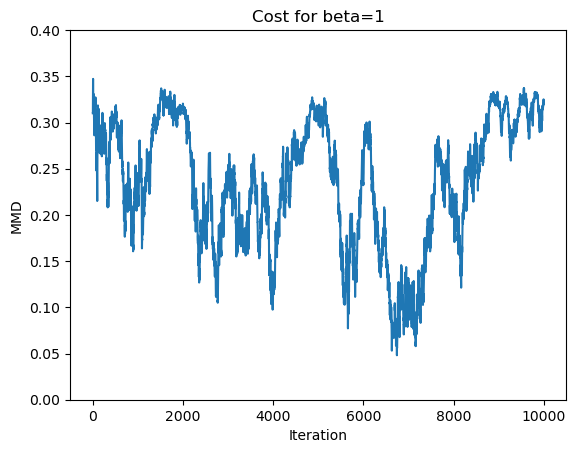

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.022339 | Elapsed Time: 636.23s | Estimated Remaining Time: 0.00s


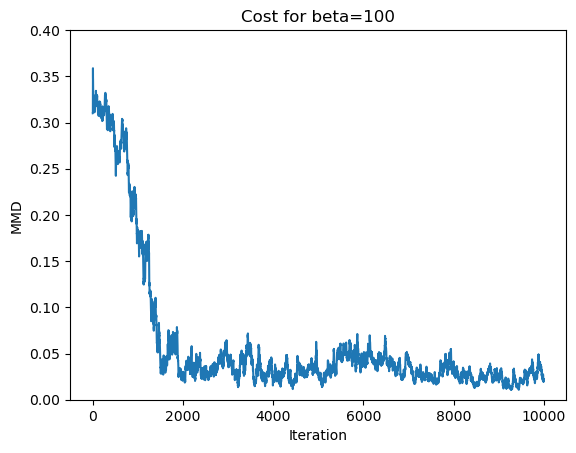

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.026700 | Elapsed Time: 696.78s | Estimated Remaining Time: 0.00s


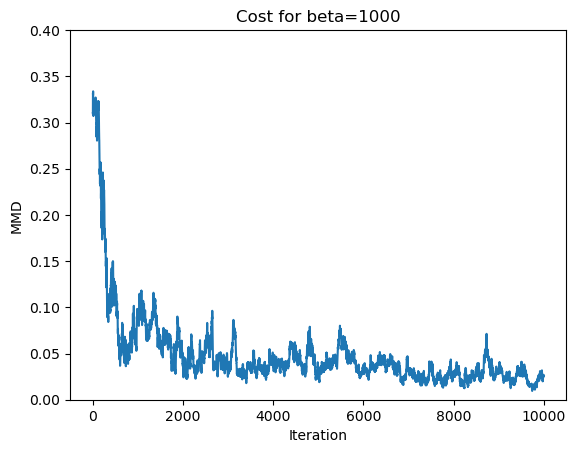

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.033116 | Elapsed Time: 638.89s | Estimated Remaining Time: 0.00s


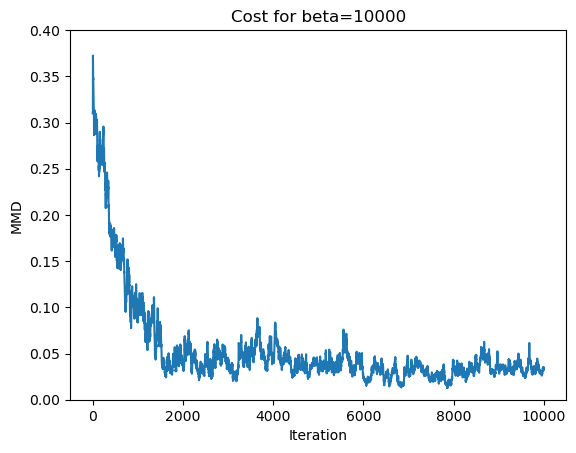

In [6]:
betas = [1,100,1000,10000]  # Set the range of betas for the sim 
gaussian = (6,2)   # For the gen data 
number_of_data_points = 5000
n_qubits = 8 # For the 
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)


init_key, train_key = random.split(random_key)

# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key
mu = gaussian[0]                   # Mean of the Gaussian distribution
sigma = gaussian[1]                # Standard deviation of the Gaussian distribution

# Generate Gaussian distribution
data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * sigma + mu

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_beta = {} 

for beta in betas:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

    data_probs = jnp.ones(len(data)) / len(data)

    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for beta={beta}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    burn_in = 9900
    av_probs = compute_av_probs(params, burn_in)

    results_beta[str(beta)] = (jnp.square(jnp.abs(final_st.flatten())),av_probs, cost_vals, total_run_time, params) 

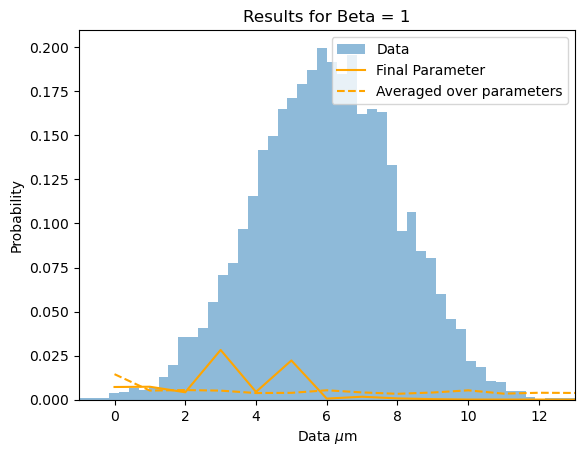

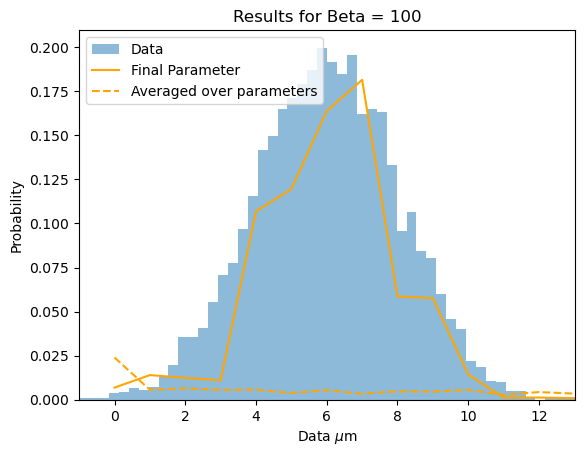

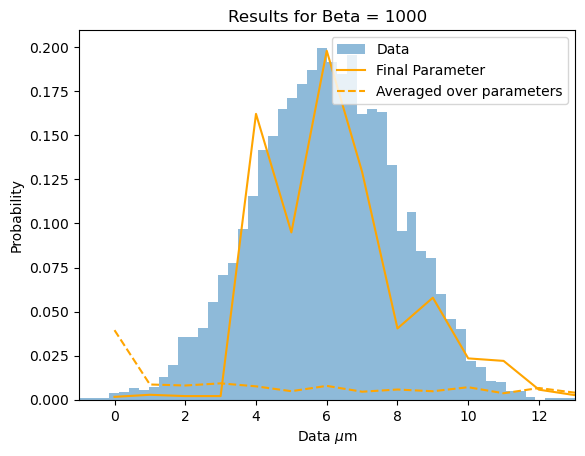

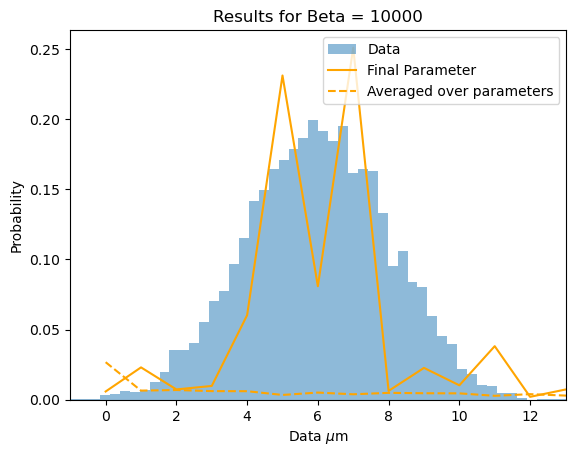

In [7]:
# Iterate over the results_beta dictionary and plot each set of results
for beta, (final_st, av_probs, cost,time,_ ) in results_beta.items():
    fig = plot_histogram_and_line(data, av_probs, final_st)
    plt.title(f"Results for Beta = {beta}")
    plt.show()

In [8]:
# Save results_beta to a file
with open('guassia_data/results_beta.pkl', 'wb') as file:
    pickle.dump(results_beta, file)

In [ ]:
# qbits 
# dept
# sigma

In [14]:
## Ensure the circuit is correct
# n_qubits_list = [6,8,10,12] # For the 
# for n_qubits in n_qubits_list:
#     gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
#     print(f'Number of qbit = {n_qubits}')
#     qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=200);
#     print()

Number of qbit = 6
q0: -----H-----Rx[0]---Ry[6]-----◯-----------------------------Rx[12]--Ry[18]------------◯-----------------------------Rx[24]--Ry[30]------------◯-----------------------------Rx[36]--Ry[42]--------
                                 |                                                       |                                                       |                                                   
q1: -----H-----Rx[1]---Ry[7]-----CZ------◯---------------------Rx[13]--Ry[19]------------CZ------◯---------------------Rx[25]--Ry[31]------------CZ------◯---------------------Rx[37]--Ry[43]--------
                                         |                                                       |                                                       |                                           
q2: -----H-----Rx[2]---Ry[8]-------------CZ------◯-------------Rx[14]--Ry[20]--------------------CZ------◯-------------Rx[26]--Ry[32]--------------------CZ------◯-------------Rx[38]--Ry[44]

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.013381 | Elapsed Time: 584.01s | Estimated Remaining Time: 0.00s


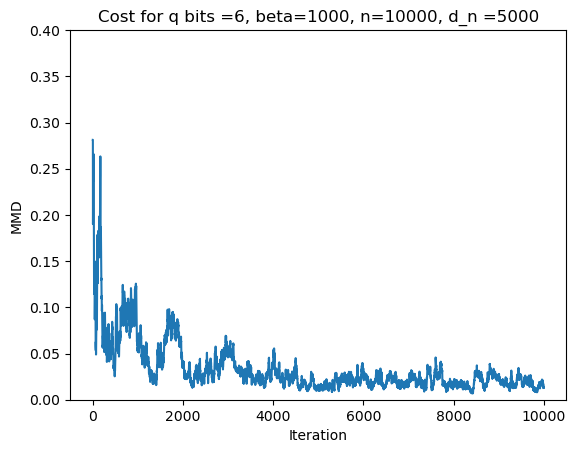

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.020298 | Elapsed Time: 645.74s | Estimated Remaining Time: 0.00s


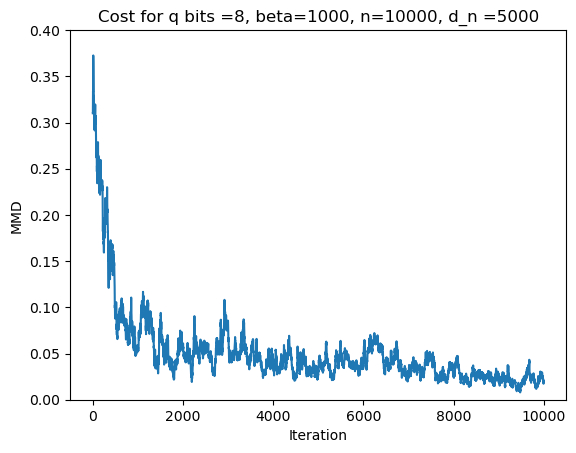

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.017750 | Elapsed Time: 858.61s | Estimated Remaining Time: 0.00s


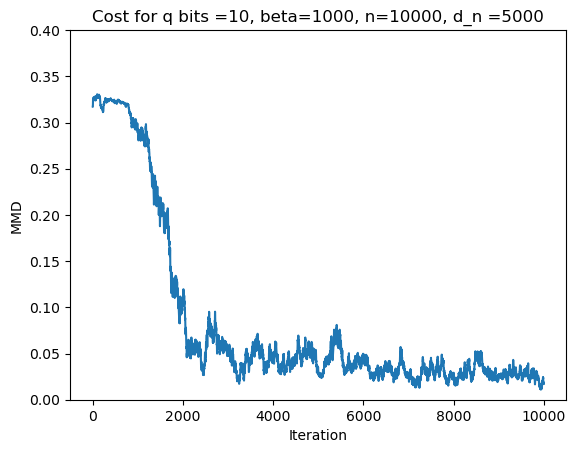

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.320782 | Elapsed Time: 4510.12s | Estimated Remaining Time: 0.00ss


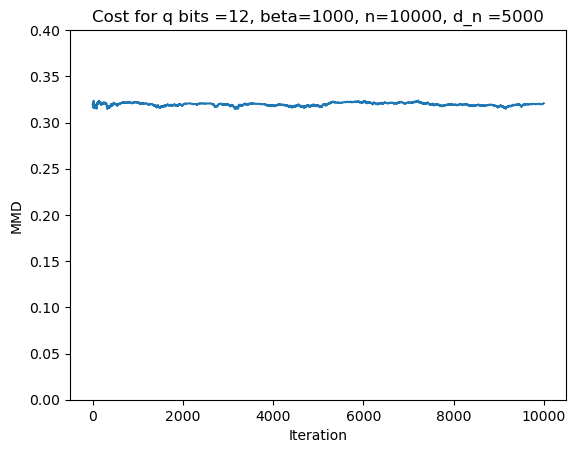

In [16]:
beta = 1000  # Set the range of betas for the sim 
gaussian = (6,2)   # For the gen data 
number_of_data_points = 5000
n_qubits_list = [6,8,10,12] # For the 
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)


init_key, train_key = random.split(random_key)

# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key
mu = gaussian[0]                   # Mean of the Gaussian distribution
sigma = gaussian[1]                # Standard deviation of the Gaussian distribution

# Generate Gaussian distribution
data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * sigma + mu

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_qubits = {} 

for n_qubits in n_qubits_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

    data_probs = jnp.ones(len(data)) / len(data)

    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    burn_in = n_steps - 100
    av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(
    params[burn_in:]
    ).mean(0)

    results_qubits[str(n_qubits)] = (jnp.square(jnp.abs(final_st.flatten())),av_probs, cost_vals,total_run_time, params) 

# Save results_beta to a file
with open('guassia_data/results_qubits.pkl', 'wb') as file:
    pickle.dump(results_qubits, file)
    


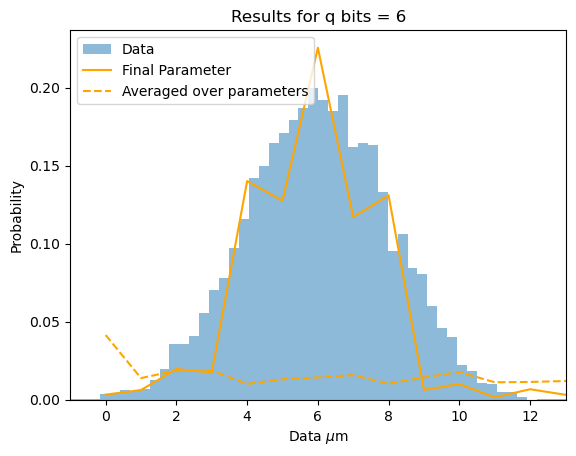

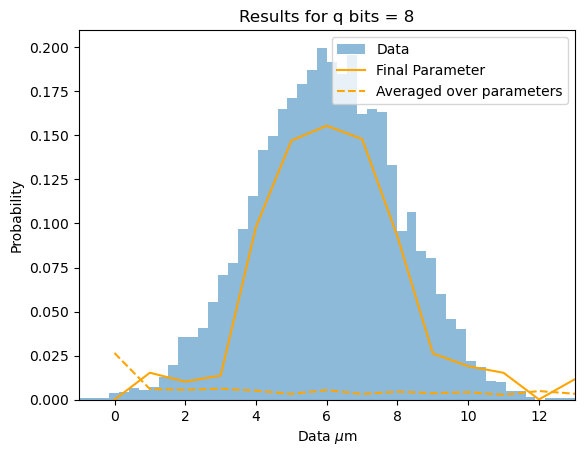

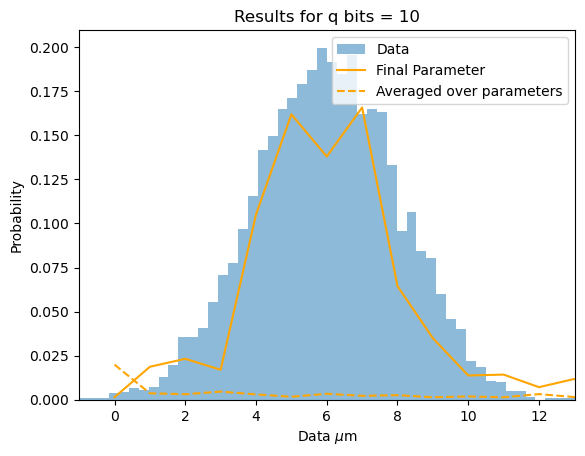

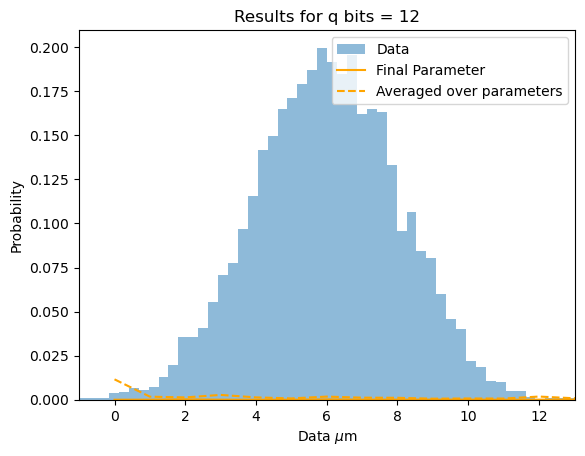

In [18]:
# Iterate over the results_beta dictionary and plot each set of results
for qbits, (final_st, av_probs, cost,time,_) in results_qubits.items():
    fig = plot_histogram_and_line(data, av_probs, final_st)
    plt.title(f"Results for q bits = {qbits}")
    plt.show()

In [10]:
## Ensure the circuit is correct
circuit_depth_list = [2,3,4]
for circuit_depth in circuit_depth_list:
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    print(f'circuit_depth = {circuit_depth}')
    qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=200);
    print()

circuit_depth = 2
q0: ------H-----Rx[0]---Ry[12]----◯-----------------------------------------------------------------------------Rx[24]--Ry[36]------------◯-----------------------------------------------------------------------------Rx[48]--Ry[60]--------
                                  |                                                                                                       |                                                                                                   
q1: ------H-----Rx[1]---Ry[13]----CZ------◯---------------------------------------------------------------------Rx[25]--Ry[37]------------CZ------◯---------------------------------------------------------------------Rx[49]--Ry[61]--------
                                          |                                                                                                       |                                                                                           
q2: ------H-----Rx[2]---Ry

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.044017 | Elapsed Time: 765.25s | Estimated Remaining Time: 0.00s


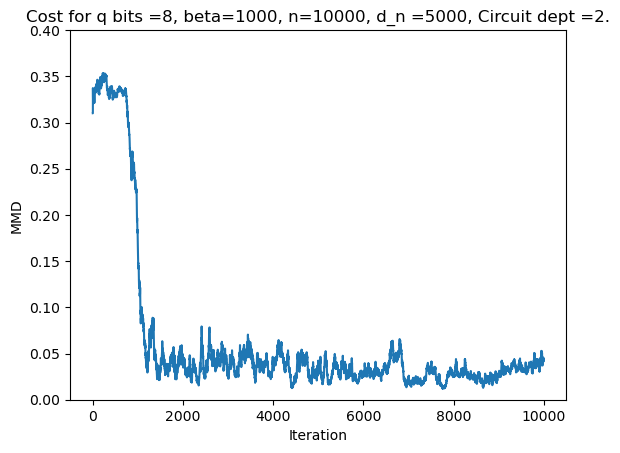

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.026942 | Elapsed Time: 846.79s | Estimated Remaining Time: 0.00s


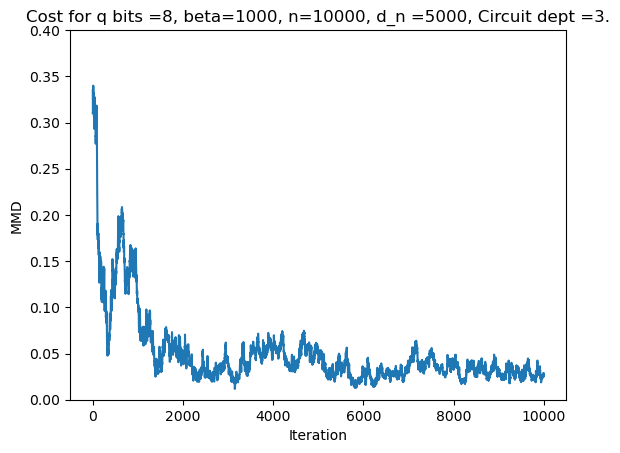

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.048499 | Elapsed Time: 825.58s | Estimated Remaining Time: 0.00s


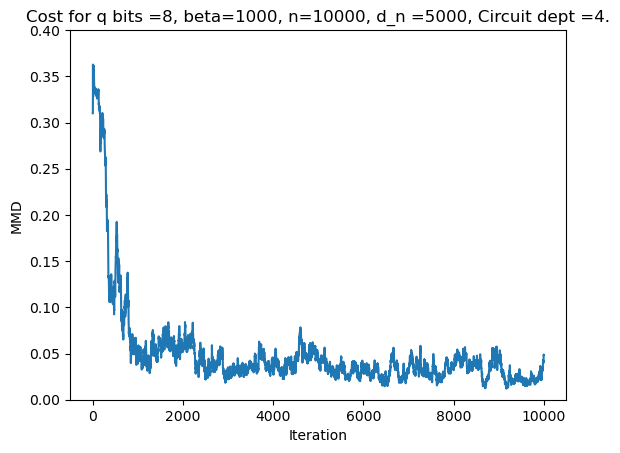

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.017008 | Elapsed Time: 1708.36s | Estimated Remaining Time: 0.00s


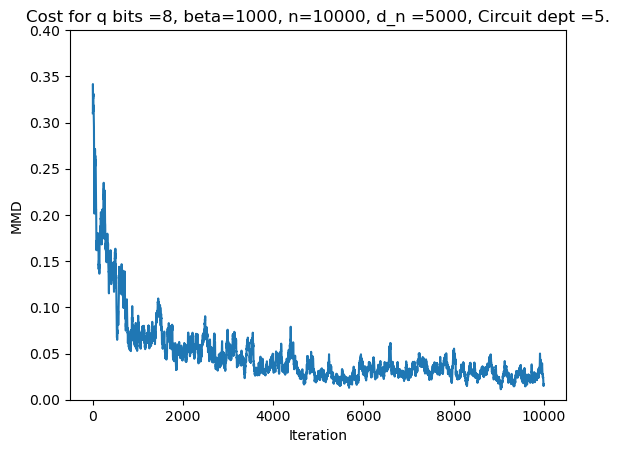

In [10]:
circuit_depth_list = [2,3,4,5]


beta = 1000  # Set the range of betas for the sim 
gaussian = (6,2)   # For the gen data 
number_of_data_points = 5000
n_qubits  = 8 # For the 
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)

init_key, train_key = random.split(random_key)

# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key
mu = gaussian[0]                   # Mean of the Gaussian distribution
sigma = gaussian[1]                # Standard deviation of the Gaussian distribution

# Generate Gaussian distribution
data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * sigma + mu

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_circuit_depth = {} 

for circuit_depth in circuit_depth_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

    data_probs = jnp.ones(len(data)) / len(data)

    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}, Circuit dept ={circuit_depth}.')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    burn_in = n_steps - 100
    av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(
    params[burn_in:]
    ).mean(0)

    results_circuit_depth[str(circuit_depth)] = (jnp.square(jnp.abs(final_st.flatten())),av_probs, cost_vals,total_run_time,params) 



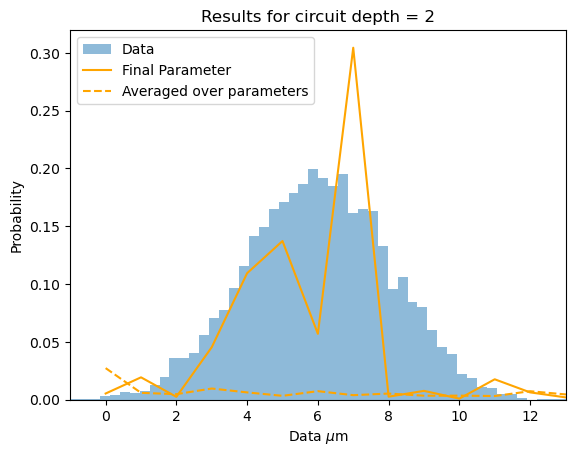

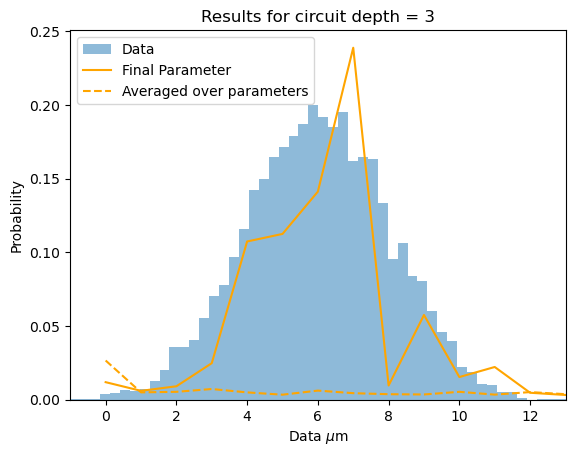

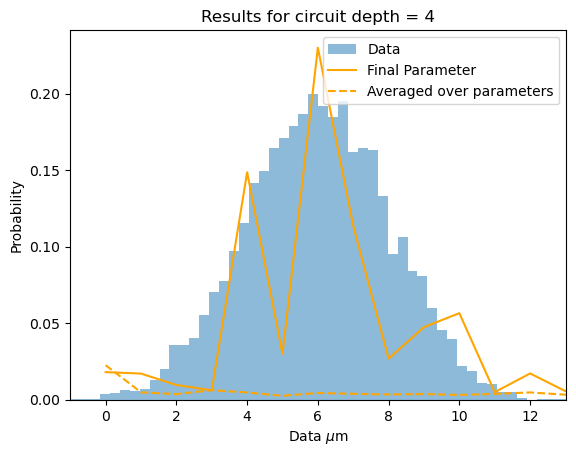

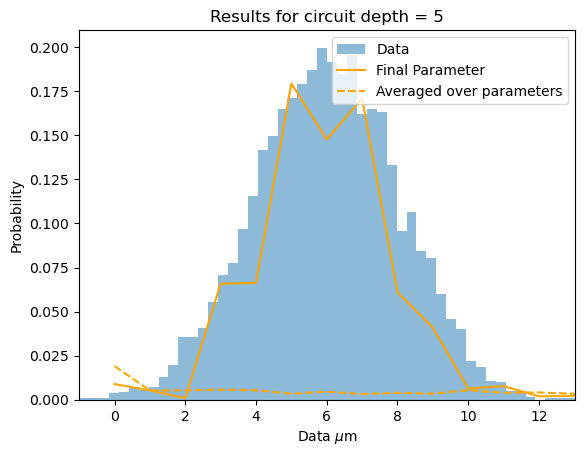

In [12]:
# Iterate over the results_beta dictionary and plot each set of results
for circuit_depth, (final_st, av_probs, cost,time, _) in results_circuit_depth.items():
    fig = plot_histogram_and_line(data, av_probs, final_st)
    plt.title(f"Results for circuit depth = {circuit_depth}")
    plt.show()

In [14]:
# Save results_beta to a file
with open('guassia_data/results_circuit_depth.pkl', 'wb') as file:
    pickle.dump(results_circuit_depth, file)
    

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.018580 | Elapsed Time: 611.06s | Estimated Remaining Time: 0.00s


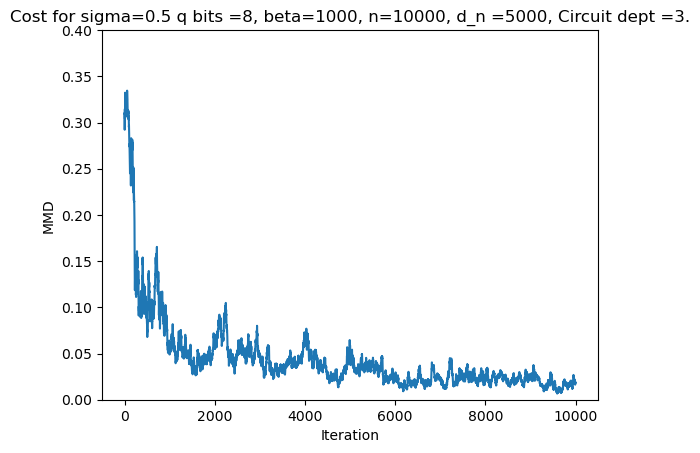

running sim
Progress: |█-----------------------------| 6.38% | Iteration: 638/10000 | Cost: 0.136454 | Elapsed Time: 46.86s | Estimated Remaining Time: 687.64ss

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.054403 | Elapsed Time: 618.10s | Estimated Remaining Time: 0.00s


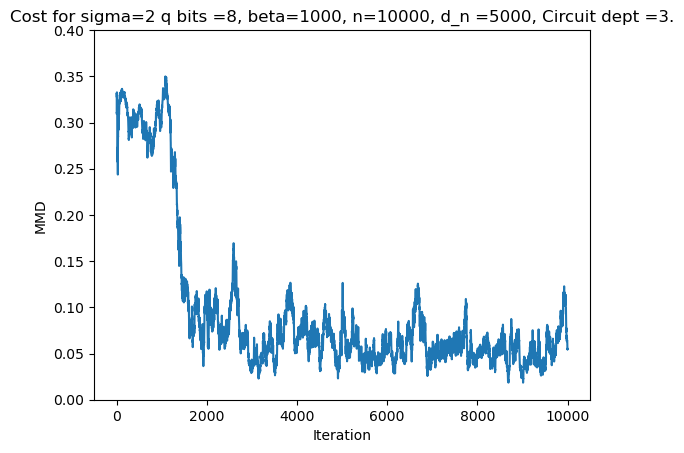

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.276876 | Elapsed Time: 616.04s | Estimated Remaining Time: 0.00s


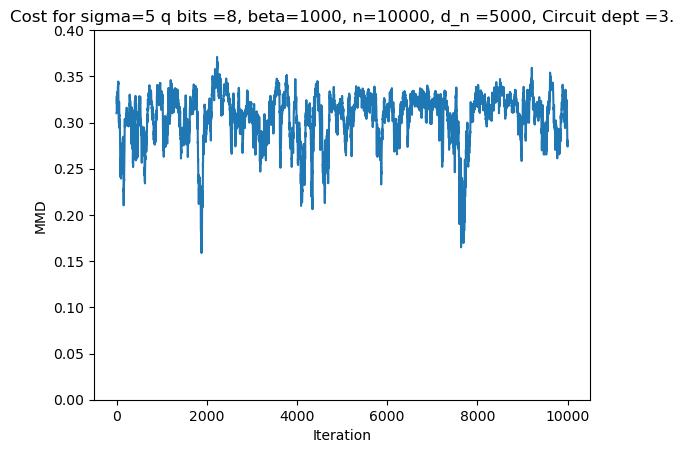

In [6]:
sigma_list = [0.1,0.5,1,2,5]


beta = 1000  # Set the range of betas for the sim 
gaussian = (6,2)   # For the gen data 
number_of_data_points = 5000
n_qubits  = 8 # For the 
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)

init_key, train_key = random.split(random_key)

# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key
# Generate Gaussian distribution
data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * gaussian[1]  + gaussian[0]    

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_sigmas = {} 

for sigma in sigma_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    
    M, M_inv, mu_inv, N_d, kBT, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1.

    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

    data_probs = jnp.ones(len(data)) / len(data)

    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for sigma={sigma} q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}, Circuit dept ={circuit_depth}.')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    burn_in = n_steps - 100
    av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(
    params[burn_in:]
    ).mean(0)

    results_sigmas[str(sigma)] = (jnp.square(jnp.abs(final_st.flatten())),av_probs, cost_vals,total_run_time , params ) 

    
# Save results_beta to a file
with open('guassia_data/results_sigma.pkl', 'wb') as file:
    pickle.dump(results_sigmas, file)

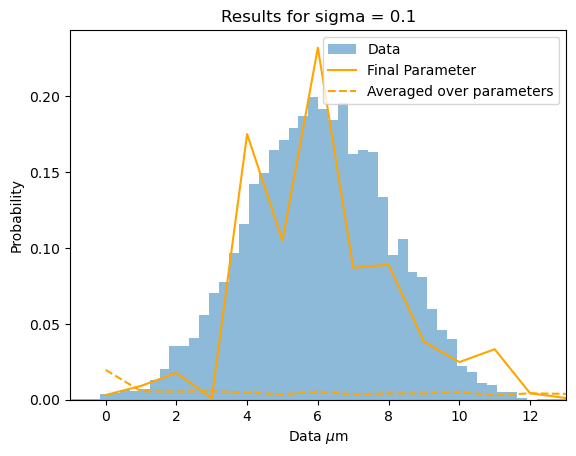

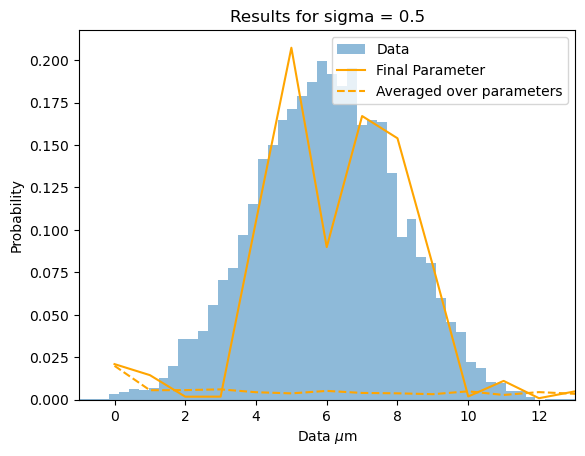

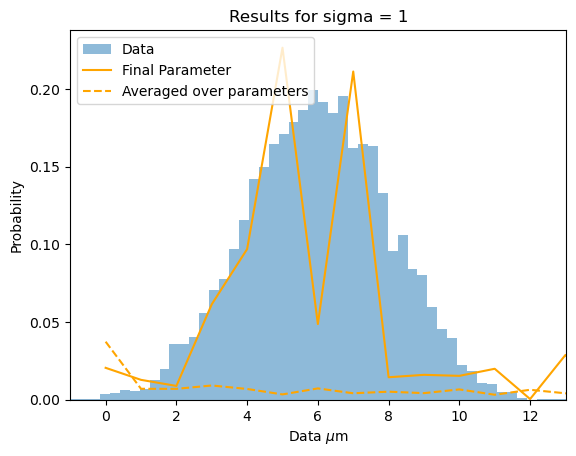

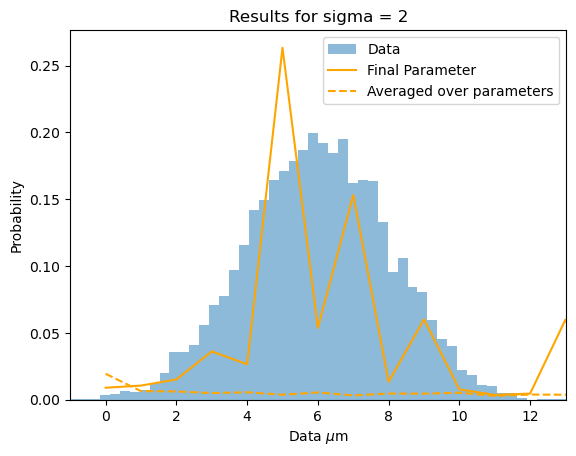

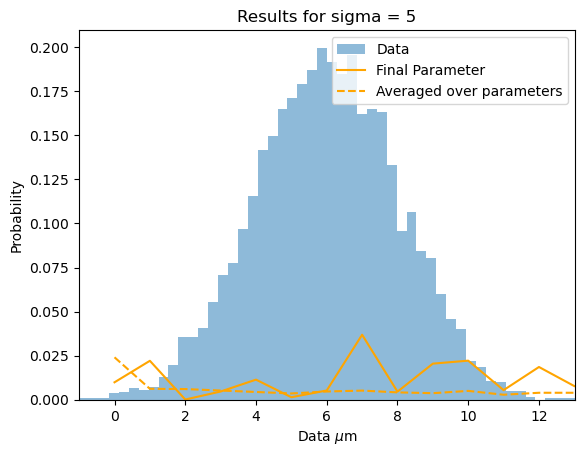

In [8]:
# Iterate over the results_beta dictionary and plot each set of results
for sigma, (final_st, av_probs, cost,time,_) in results_sigmas.items():
    fig = plot_histogram_and_line(data, av_probs, final_st)
    plt.title(f"Results for sigma = {sigma}")
    plt.show()